In [1]:
import hydra
from hydra import initialize, compose
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import seaborn as sns
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy.stats import norm, gaussian_kde
from scipy import stats
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error
import torch
from torch.distributions import Normal, Categorical

from model import BaseTransformer
import time

import os
import copy


from utils.misc import *
from utils.gp_active_learning import active_learning_with_gp
from utils import compute_ll, compute_rmse, remove_design, load_checkpoint, add_design, create_target_mask, select_targets_by_mask
from tasks import *

import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
matplotlib.rcParams.update({
        'font.family': 'times',
        'font.size': 14.0,
        'lines.linewidth': 2,
        'lines.antialiased': True,
        'axes.facecolor': 'fdfdfd',
        'axes.edgecolor': '777777',
        'axes.linewidth': 1,
        'axes.titlesize': 'medium',
        'axes.labelsize': 'medium',
        'axes.axisbelow': True,
        'xtick.major.size': 0,  # major tick size in points
        'xtick.minor.size': 0,  # minor tick size in points
        'xtick.major.pad': 6,  # distance to major tick label in points
        'xtick.minor.pad': 6,  # distance to the minor tick label in points
        'xtick.color': '333333',  # color of the tick labels
        'xtick.labelsize': 'medium',  # fontsize of the tick labels
        'xtick.direction': 'in',  # direction: in or out
        'ytick.major.size': 0,  # major tick size in points
        'ytick.minor.size': 0,  # minor tick size in points
        'ytick.major.pad': 6,  # distance to major tick label in points
        'ytick.minor.pad': 6,  # distance to the minor tick label in points
        'ytick.color': '333333',  # color of the tick labels
        'ytick.labelsize': 'medium',  # fontsize of the tick labels
        'ytick.direction': 'in',  # direction: in or out
        'axes.grid': False,
        'grid.alpha': 0.3,
        'grid.linewidth': 1,
        'legend.fancybox': True,
        'legend.fontsize': 'Small',
        'figure.figsize': (2.5, 2.5),
        'figure.facecolor': '1.0',
        'figure.edgecolor': '0.5',
        'hatch.linewidth': 0.1,
        'text.usetex': True
    })


In [3]:
def load_config_and_model(path, config_name="config.yaml", file_name="aae.pth"):
    """
    Loads configuration and model from a specified path. Instantiates the model components
    (embedder, encoder, and head) based on the configuration, and loads the model's checkpoint.
    """
    config_path = path + ".hydra/"
    print(config_path)
    with initialize(version_base=None, config_path=config_path):
        cfg = compose(config_name=config_name)

        embedder = hydra.utils.instantiate(cfg.embedder)
        encoder = hydra.utils.instantiate(cfg.encoder)
        head = hydra.utils.instantiate(cfg.head)
        model = BaseTransformer(embedder, encoder, head)

        # file_path = os.path.join(path, 'model', file_name)
        # model.load_state_dict(torch.load(file_path, map_location=torch.get_default_device(), weights_only=True))

        ckpt = torch.load(os.path.join(path, file_name), map_location=torch.get_default_device(), weights_only=False)

        model.load_state_dict(ckpt["model"])
    return cfg, model

In [4]:
def calculate_gmm_uncertainties(mixture_means, mixture_stds, mixture_weights):
    """
    Calculate the uncertainty of GMM predictions for each query point.
    
    Args:
        mixture_means: [batch_size, n_query, n_components] tensor of means
        mixture_stds: [batch_size, n_query, n_components] tensor of standard deviations
        mixture_weights: [batch_size, n_query, n_components] or [batch_size, n_components] weights
    
    Returns:
        uncertainties: [batch_size, n_query] tensor of uncertainties
    """
    batch_size, n_query, n_components = mixture_means.shape
    
    # Adjust weights shape if necessary
    if len(mixture_weights.shape) == 2:  # [batch_size, n_components]
        # Expand to [batch_size, n_query, n_components]
        weights = mixture_weights.unsqueeze(1).expand(batch_size, n_query, n_components)
    else:
        weights = mixture_weights
    
    # Calculate weighted mean for each query point
    # Sum along component dimension (dim=2)
    weighted_means = torch.sum(weights * mixture_means, dim=2)  # [batch_size, n_query]
    
    # Calculate variance for GMM: var = Σ weight * (std^2 + (mean - weighted_mean)^2)
    # First, calculate (mean - weighted_mean)^2
    mean_diffs_squared = (mixture_means - weighted_means.unsqueeze(2))**2  # [batch_size, n_query, n_components]
    
    # Calculate total variance
    total_variance = torch.sum(
        weights * (mixture_stds**2 + mean_diffs_squared), 
        dim=2
    )  # [batch_size, n_query]
    
    uncertainties = total_variance
    
    return uncertainties

In [13]:
def calculate_targeted_log_prob(eval_set, cfg, model, experiment, T, acquisition="aae", attend_to="data", visualize=True):
    """
    Visualize model predictions over multiple time steps in a grid layout.
    
    Args:
        eval_set: The evaluation dataset
        cfg: Configuration object
        model: The trained model
        T: Total number of time steps to run
        acquisition: Acquisition strategy ("aae", "random", or "uncertainty_sampling")
        attend_to: Which targets to attend to ("data" or "theta")
        visualize: Whether to generate visualization
    
    Returns:
        log_probs: Tensor of log probabilities at each time step [T, batch_size]
        rmse_values: Tensor of RMSE values at each time step [T, batch_size]
    """
    
    batch = copy.deepcopy(eval_set)
    batch_size = batch.context_x.shape[0]
    mask_type = cfg.task.mask_type[0]

    target_mask = create_target_mask(
        mask_type,
        cfg.task.embedding_type,
        cfg.task.n_target_data,
        cfg.task.n_target_theta,
        cfg.task.n_selected_targets,
        cfg.task.predefined_masks,
        None,
        cfg.task.mask_index,
        attend_to,
    )
    if acquisition != "aae":
        batch.target_mask = None
    else:
        batch.target_mask = target_mask

    # Initialize tensors to store results
    log_probs = torch.zeros((T, batch_size), device=batch.context_x.device)
    rmse_values = torch.zeros((T, batch_size), device=batch.context_x.device)
    all_time = torch.zeros((T), device=batch.context_x.device)
    
    # Setup the figure and subplots
    if visualize:
        # Fixed number of columns
        cols = 5
        # Calculate number of rows needed
        rows = (T + cols - 1) // cols  # Ceiling division
        
        fig = plt.figure(figsize=(16, 2.5*rows))
    
    batch_idx = 0  # Work with first batch for visualization
    
    for t in range(T):

        if cfg.time_token:
            batch.t = torch.tensor([t/T])
            
        # Forward pass
        outs = model.forward(batch, predict=True)
        
        design_out = outs.design_out
        posterior_out = outs.posterior_out
        posterior_out_query = outs.posterior_out_query
        
        # Calculate log probability
        target_ll = compute_ll(
            batch.target_all,
            posterior_out.mixture_means,
            posterior_out.mixture_stds,
            posterior_out.mixture_weights
        )  # [batch_size, n_targets]

        # Calculate squared errors
        weighted_means = torch.sum(posterior_out.mixture_means * posterior_out.mixture_weights, dim=-1)  # [batch_size, n_targets]
        squared_errors = (batch.target_all.squeeze(-1) - weighted_means) ** 2  # [batch_size, n_targets]
        
        if mask_type == "none":
            masked_target_ll = target_ll
            # For RMSE, compute per-batch element (mean across targets, then sqrt)
            masked_target_rmse = torch.sqrt(torch.mean(squared_errors, dim=-1))  # [batch_size]
        else:
            masked_target_ll = select_targets_by_mask(target_ll, target_mask)  # [batch_size, selected_targets]
            masked_squared_errors = select_targets_by_mask(squared_errors, target_mask)  # [batch_size, selected_targets]
            masked_target_rmse = torch.sqrt(torch.mean(masked_squared_errors, dim=-1))  # [batch_size]
            
        # Store per-batch log probs (mean across selected targets)
        log_probs[t] = masked_target_ll.mean(dim=-1)  # [batch_size]
        rmse_values[t] = masked_target_rmse  # [batch_size]

        # Select next design point
        if acquisition == "aline":
            index = design_out.idx
        elif acquisition == "random":
            query_size = batch.query_x.shape[1]
            # Generate random indices within the valid range for each batch element
            index = torch.randint(0, query_size, (batch_size, 1), device=batch.query_x.device)
        elif acquisition == "uncertainty_sampling":
            uncertainties = calculate_gmm_uncertainties(
                posterior_out_query.mixture_means,
                posterior_out_query.mixture_stds,
                posterior_out_query.mixture_weights
            )
            # Select the point with highest uncertainty
            index = torch.argmax(uncertainties, dim=1, keepdim=True)
        else:
            raise NotImplementedError
            
        # Get the next design point
        next_design_x = torch.gather(
            batch.query_x, 1, 
            index.unsqueeze(2).expand(batch_size, 1, cfg.task.dim_x)
        )
        
        batch = experiment.update_batch(batch, index)

        # Visualize all steps
        if visualize:
            ax = fig.add_subplot(rows, cols, t + 1)
            
            # Extract data for the first batch
            x_values = batch.target_x[batch_idx].detach().cpu()
            y_values = batch.target_y[batch_idx].detach().cpu()
            
            means = posterior_out.mixture_means[batch_idx].detach().cpu()
            stds = posterior_out.mixture_stds[batch_idx].detach().cpu()
            weights = posterior_out.mixture_weights[batch_idx].detach().cpu()
            
            # Sort by x values
            x_flat = x_values.flatten().numpy()
            indices = np.argsort(x_flat)
            
            all_x = []
            all_means = []
            all_lower = []
            all_upper = []
            
            # Compute weighted stats for each target point
            for i in range(x_values.shape[0]):
                x_val = x_values[i, 0].item()
                component_means = means[i].numpy()
                component_stds = stds[i].numpy()
                component_weights = weights[i].numpy()
                
                weighted_mean = np.sum(component_weights * component_means)
                weighted_variance = np.sum(component_weights * (component_stds**2 + 
                                                              (component_means - weighted_mean)**2))
                weighted_std = np.sqrt(weighted_variance)
                
                all_x.append(x_val)
                all_means.append(weighted_mean)
                all_lower.append(weighted_mean - 2*weighted_std)
                all_upper.append(weighted_mean + 2*weighted_std)
            
            # Convert to numpy arrays and sort by x value
            all_x = np.array(all_x)
            all_means = np.array(all_means)
            all_lower = np.array(all_lower)
            all_upper = np.array(all_upper)
            
            sort_indices = np.argsort(all_x)
            all_x = all_x[sort_indices]
            all_means = all_means[sort_indices]
            all_lower = all_lower[sort_indices]
            all_upper = all_upper[sort_indices]
            
            # Ground truth
            all_gt = y_values.numpy().reshape(-1)
            all_gt = all_gt[sort_indices]
            
            # Compute MSE
            mse = mean_squared_error(all_gt, all_means)
            
            # Plot
            ax.plot(all_x, all_means, 'C0', label='Prediction')
            ax.fill_between(all_x, all_lower, all_upper, color='b', alpha=0.2)
            ax.plot(all_x, all_gt, 'C3', label='Ground Truth')
            ax.scatter(all_x, all_gt, color='black', s=10, label='Targets')
            
            # Plot context points
            context_x = batch.context_x[batch_idx].detach().cpu().numpy()
            context_y = batch.context_y[batch_idx].detach().cpu().numpy()
            ax.scatter(context_x, context_y, color='C2', s=30, marker='o', label='Context')
            
            # Plot next query
            next_x = next_design_x[batch_idx].detach().cpu().numpy()
            ax.axvline(x=next_x, color="r", linestyle="--", linewidth=1.5, label="Next Query")
            
            # Set title and labels
            # ax.set_title(f'Step {t+1}, MSE={mse:.4f}')
            ax.set_title(f'Step {t+1}', fontsize=16)
            
            # Add x-label only for bottom row
            if t >= (rows-1)*cols:
                ax.set_xlabel('x', fontsize=16)
            
            # Add y-label only for leftmost column
            if t % cols == 0:
                ax.set_ylabel('y', fontsize=16)
            
            # Only add legend to the first plot to save space
            if t == 0:
                ax.legend(loc='upper right', fontsize='small')
            
            # ax.grid(True, alpha=0.3)
    
    if visualize:
        plt.tight_layout()
        # plt.savefig("figures/al_strategy_visualization.pdf", dpi=300)
        plt.show()
    
    return log_probs, rmse_values

In [6]:
def plot_metrics_with_confidence(
    metrics_data_list, 
    metric_names, 
    x_range=None, 
    colors=None, 
    markers=None, 
    title="", 
    xlabel="Number of Steps", 
    ylabel="RMSE", 
    figsize=(5, 4), 
    marker_frequency=5, 
    legend_loc='upper right'
):
    # Ensure all input data is numpy arrays
    metrics_data_list = [
        data.detach().numpy() if torch.is_tensor(data) else data 
        for data in metrics_data_list
    ]
    
    # Get number of time steps
    T = metrics_data_list[0].shape[0]
    
    # Set default x_range if not provided
    if x_range is None:
        x_range = (1, T)
        
    # Create x-axis array
    x = np.arange(x_range[0], x_range[1] + 1)
    
    # Set default colors if not provided
    if colors is None:
        colors = ['#8172b3', '#937860', '#4c72b0', '#dd8452', '#55a868', '#c44e52', ]
    
    # Set default markers if not provided
    if markers is None:
        markers = ['o', 's', '^', 'D', 'X', 'P']
    
    # Set style
    plt.style.use('seaborn-v0_8-paper')
    sns.set_palette("colorblind")
    plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    # Helper function to calculate confidence intervals
    def get_confidence_interval(data):
        n_trials = data.shape[1]
        std = data.std(axis=1)
        ci = 1.96 * std / np.sqrt(n_trials)  # 1.96 for 95% CI under normal approximation
        return ci
    
    # Helper function to plot with confidence bands
    def plot_with_confidence(ax, x, mean, ci, label, color, marker):
        ax.plot(x, mean, label=label, color=color, linewidth=2, 
                marker=marker, markevery=marker_frequency, markersize=7, markeredgecolor='white')
        ax.fill_between(x, mean - ci, mean + ci, color=color, alpha=0.15)
    
    # Plot each metric
    for i, (data, label) in enumerate(zip(metrics_data_list, metric_names)):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        mean = data.mean(axis=1)
        ci = get_confidence_interval(data)
        
        # Ensure data length matches x-axis
        if mean.shape[0] < len(x):
            # Pad with NaN or truncate as needed
            padded_mean = np.full(len(x), np.nan)
            padded_mean[:mean.shape[0]] = mean
            
            padded_ci = np.full(len(x), np.nan)
            padded_ci[:ci.shape[0]] = ci
            
            plot_with_confidence(ax, x, padded_mean, padded_ci, label, color, marker)
        elif mean.shape[0] > len(x):
            # Truncate to match x length
            plot_with_confidence(ax, x, mean[:len(x)], ci[:len(x)], label, color, marker)
        else:
            plot_with_confidence(ax, x, mean, ci, label, color, marker)
    
    # Customize the plot
    ax.set_xlabel(xlabel, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    if title:
        ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    
    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    
    # Add grid with lower opacity
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend with a nice border
    legend = ax.legend(frameon=True, framealpha=1, edgecolor='gray', 
                      fontsize=10, loc=legend_loc)
    legend.get_frame().set_linewidth(0.5)
    
    # Set axis limits
    # ax.set_ylim(bottom=0)
    ax.set_xlim(x_range[0], x_range[1])
    
    # Add minor ticks
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

In [5]:
def calculate_targeted_log_prob(eval_set, cfg, model, experiment, T, acquisition="aae", attend_to="data", visualize=True):
    """
    Visualize model predictions over multiple time steps, focusing only on the predicted function shape.
    Supports both 1D and 2D input visualization without displaying context points.
    
    Args:
        eval_set: The evaluation dataset
        cfg: Configuration object
        model: The trained model
        experiment: The experimental task
        T: Total number of time steps to run
        acquisition: Acquisition strategy ("aae", "random", or "uncertainty_sampling")
        attend_to: Which targets to attend to ("data" or "theta")
        visualize: Whether to generate visualization
    
    Returns:
        log_probs: Tensor of log probabilities at each time step [T, batch_size]
        rmse_values: Tensor of RMSE values at each time step [T, batch_size]
    """
    import time
    import copy
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from sklearn.metrics import mean_squared_error
    from matplotlib import cm
    import torch
    
    batch = copy.deepcopy(eval_set)
    batch_size = batch.context_x.shape[0]
    mask_type = cfg.task.mask_type[0]
    
    # Check if inputs are 1D or 2D
    input_dim = cfg.task.dim_x
    is_2d = (input_dim == 2)

    batch.target_mask = create_target_mask(
        mask_type,
        cfg.task.embedding_type,
        cfg.task.n_target_data,
        cfg.task.n_target_theta,
        cfg.task.n_selected_targets,
        cfg.task.predefined_masks,
        None,
        cfg.task.mask_index,
        attend_to,
    )

    # Initialize tensors to store results
    log_probs = torch.zeros((T, batch_size), device=batch.context_x.device)
    rmse_values = torch.zeros((T, batch_size), device=batch.context_x.device)
    all_time = torch.zeros((T), device=batch.context_x.device)
    
    # Setup the figure and subplots
    if visualize:
        # Fixed number of columns
        cols = min(4, T)
        # Calculate number of rows needed
        rows = (T + cols - 1) // cols  # Ceiling division
        
        if is_2d:
            # For 2D inputs (3D visualization), use a larger figure size
            fig = plt.figure(figsize=(16, 4*rows))
        else:
            # For 1D inputs (2D visualization)
            fig = plt.figure(figsize=(16, 3*rows))
    
    batch_idx = 0  # Work with first batch for visualization
    
    for t in range(T):
        start_time = time.time()
        if cfg.time_token:
            batch.t = torch.tensor([t/T])
            
        # Forward pass
        outs = model.forward(batch, predict=True)
        design_out = outs.design_out
        posterior_out = outs.posterior_out
        posterior_out_query = outs.posterior_out_query
        
        # Calculate log probability
        target_ll = compute_ll(
            batch.target_all,
            posterior_out.mixture_means,
            posterior_out.mixture_stds,
            posterior_out.mixture_weights
        )  # [batch_size, n_targets]

        # Calculate squared errors
        weighted_means = torch.sum(posterior_out.mixture_means * posterior_out.mixture_weights, dim=-1)  # [batch_size, n_targets]
        squared_errors = (batch.target_all.squeeze(-1) - weighted_means) ** 2  # [batch_size, n_targets]
        
        if mask_type == "none":
            masked_target_ll = target_ll
            # For RMSE, compute per-batch element (mean across targets, then sqrt)
            masked_target_rmse = torch.sqrt(torch.mean(squared_errors, dim=-1))  # [batch_size]
        else:
            masked_target_ll = select_targets_by_mask(target_ll, batch.target_mask)  # [batch_size, selected_targets]
            masked_squared_errors = select_targets_by_mask(squared_errors, batch.target_mask)  # [batch_size, selected_targets]
            masked_target_rmse = torch.sqrt(torch.mean(masked_squared_errors, dim=-1))  # [batch_size]
            
        # Store per-batch log probs (mean across selected targets)
        log_probs[t] = masked_target_ll.mean(dim=-1)  # [batch_size]
        rmse_values[t] = masked_target_rmse  # [batch_size]

        # Select next design point
        if acquisition == "aae":
            index = design_out.idx
        elif acquisition == "random":
            query_size = batch.query_x.shape[1]
            # Generate random indices within the valid range for each batch element
            index = torch.randint(0, query_size, (batch_size, 1), device=batch.query_x.device)
        elif acquisition == "uncertainty_sampling":
            uncertainties = calculate_gmm_uncertainties(
                posterior_out_query.mixture_means,
                posterior_out_query.mixture_stds,
                posterior_out_query.mixture_weights
            )
            # Select the point with highest uncertainty
            index = torch.argmax(uncertainties, dim=1, keepdim=True)
        else:
            raise NotImplementedError
            
        # Get the next design point
        next_design_x = torch.gather(
            batch.query_x, 1, 
            index.unsqueeze(2).expand(batch_size, 1, cfg.task.dim_x)
        )
        
        batch = experiment.update_batch(batch, index)

        all_time[t] = time.time() - start_time

        # Skip visualization if not requested
        if not visualize:
            continue
            
        # Visualization based on input dimension
        if is_2d:
            # ===== 2D Input Visualization (3D plot) =====
            ax = fig.add_subplot(rows, cols, t + 1, projection='3d')
            
            # Extract target data for the first batch
            target_x = batch.target_x[batch_idx].detach().cpu().numpy()
            target_y = batch.target_y[batch_idx].detach().cpu().numpy().flatten()
            
            # Extract posterior predictions
            means = posterior_out.mixture_means[batch_idx].detach().cpu()
            stds = posterior_out.mixture_stds[batch_idx].detach().cpu()
            weights = posterior_out.mixture_weights[batch_idx].detach().cpu()
            
            # Calculate weighted means for each target point
            weighted_mean = torch.sum(means * weights, dim=-1).numpy()
            
            # Calculate variance for uncertainty visualization
            weighted_variance = torch.sum(
                weights * (stds**2 + (means - weighted_mean.reshape(-1, 1))**2),
                dim=-1
            ).numpy()
            
            weighted_std = np.sqrt(weighted_variance)
            
            # Extract x1 and x2 coordinates
            x1 = target_x[:, 0]
            x2 = target_x[:, 1]
            
            try:
                from scipy.interpolate import griddata
                
                # Create a denser grid for better visualization
                grid_size = 50
                
                # Determine domain bounds
                x1_min, x1_max = np.min(x1), np.max(x1)
                x2_min, x2_max = np.min(x2), np.max(x2)
                
                # Add padding to the grid
                padding = 0.1 * min(x1_max - x1_min, x2_max - x2_min)
                x1_min -= padding
                x1_max += padding
                x2_min -= padding
                x2_max += padding
                
                # Create grid for smooth surface
                xi = np.linspace(x1_min, x1_max, grid_size)
                yi = np.linspace(x2_min, x2_max, grid_size)
                X1, X2 = np.meshgrid(xi, yi)
                
                # Interpolate the function values
                Z_interp = griddata((x1, x2), weighted_mean, (X1, X2), method='cubic', fill_value=np.nan)
                
                # Interpolate the uncertainty values
                U_interp = griddata((x1, x2), weighted_std, (X1, X2), method='cubic', fill_value=np.nan)
                
                # Plot the surface with a nice colormap
                surf = ax.plot_surface(X1, X2, Z_interp, cmap=cm.viridis, alpha=0.8,
                                     linewidth=0, antialiased=True)
                
                # Add a colorbar
                cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20, pad=0.1)
                cbar.set_label('Predicted Value')
                
                # Calculate and display RMSE
                mse = mean_squared_error(target_y, weighted_mean)
                rmse = np.sqrt(mse)
                
                # Set title and labels
                ax.set_title(f'Step {t+1}, RMSE={rmse:.4f}')
                ax.set_xlabel('x1')
                ax.set_ylabel('x2')
                ax.set_zlabel('y')
                
                # Set nice view angle
                ax.view_init(elev=30, azim=45)
                
                # Remove grid lines for cleaner visualization
                ax.grid(False)
                
            except (ImportError, ValueError, np.linalg.LinAlgError) as e:
                # Fall back to scatter plot if interpolation fails
                print(f"Surface interpolation failed: {e}")
                scatter = ax.scatter(x1, x2, weighted_mean, c=weighted_mean, cmap=cm.viridis, 
                                   alpha=0.7, s=30)
                
                # Add a colorbar
                fig.colorbar(scatter, ax=ax, label='Predicted Value')
                
                # Calculate and display RMSE
                mse = mean_squared_error(target_y, weighted_mean)
                rmse = np.sqrt(mse)
                
                # Set title and labels
                ax.set_title(f'Step {t+1}, RMSE={rmse:.4f}')
                ax.set_xlabel('x1')
                ax.set_ylabel('x2')
                ax.set_zlabel('y')
                
                # Set nice view angle
                ax.view_init(elev=30, azim=45)
                
        else:
            # ===== 1D Input Visualization (2D plot) =====
            ax = fig.add_subplot(rows, cols, t + 1)
            
            # Extract data for the first batch
            x_values = batch.target_x[batch_idx].detach().cpu()
            y_values = batch.target_y[batch_idx].detach().cpu()
            
            means = posterior_out.mixture_means[batch_idx].detach().cpu()
            stds = posterior_out.mixture_stds[batch_idx].detach().cpu()
            weights = posterior_out.mixture_weights[batch_idx].detach().cpu()
            
            # Sort by x values
            x_flat = x_values.flatten().numpy()
            indices = np.argsort(x_flat)
            
            all_x = []
            all_means = []
            all_lower = []
            all_upper = []
            
            # Compute weighted stats for each target point
            for i in range(x_values.shape[0]):
                x_val = x_values[i, 0].item()
                component_means = means[i].numpy()
                component_stds = stds[i].numpy()
                component_weights = weights[i].numpy()
                
                weighted_mean = np.sum(component_weights * component_means)
                weighted_variance = np.sum(component_weights * (component_stds**2 + 
                                                              (component_means - weighted_mean)**2))
                weighted_std = np.sqrt(weighted_variance)
                
                all_x.append(x_val)
                all_means.append(weighted_mean)
                all_lower.append(weighted_mean - 2*weighted_std)
                all_upper.append(weighted_mean + 2*weighted_std)
            
            # Convert to numpy arrays and sort by x value
            all_x = np.array(all_x)
            all_means = np.array(all_means)
            all_lower = np.array(all_lower)
            all_upper = np.array(all_upper)
            
            sort_indices = np.argsort(all_x)
            all_x = all_x[sort_indices]
            all_means = all_means[sort_indices]
            all_lower = all_lower[sort_indices]
            all_upper = all_upper[sort_indices]
            
            # Ground truth
            all_gt = y_values.numpy().reshape(-1)
            all_gt = all_gt[sort_indices]
            
            # Compute MSE
            mse = mean_squared_error(all_gt, all_means)
            
            # Plot prediction with uncertainty
            ax.plot(all_x, all_means, 'b-', linewidth=2, label='Prediction')
            ax.fill_between(all_x, all_lower, all_upper, color='b', alpha=0.2, label='95% CI')
            
            # Plot ground truth
            ax.plot(all_x, all_gt, 'k--', linewidth=1, alpha=0.7, label='Ground Truth')
            
            # Set title and labels
            ax.set_title(f'Step {t+1}, MSE={mse:.4f}')
            
            # Add x-label only for bottom row
            if t >= (rows-1)*cols:
                ax.set_xlabel('x')
            
            # Add y-label only for leftmost column
            if t % cols == 0:
                ax.set_ylabel('y')
            
            # Only add legend to the first plot to save space
            if t == 0:
                ax.legend(loc='upper right', fontsize='small')
            
            ax.grid(True, alpha=0.3)
    
    if visualize:
        plt.tight_layout()
        plt.show()
    
    return log_probs, rmse_values

In [15]:
batch_size = 100
T = 30

In [10]:
cfg, model = load_config_and_model(
    path="results/active_learning/aline_1d/",
    file_name="ckpt_al_1d.tar"
)

results/active_learning/aline_1d/.hydra/


In [17]:
cfg.task.n_query_init = 500
experiment = hydra.utils.instantiate(cfg.task)

eval_set = experiment.sample_batch(batch_size)

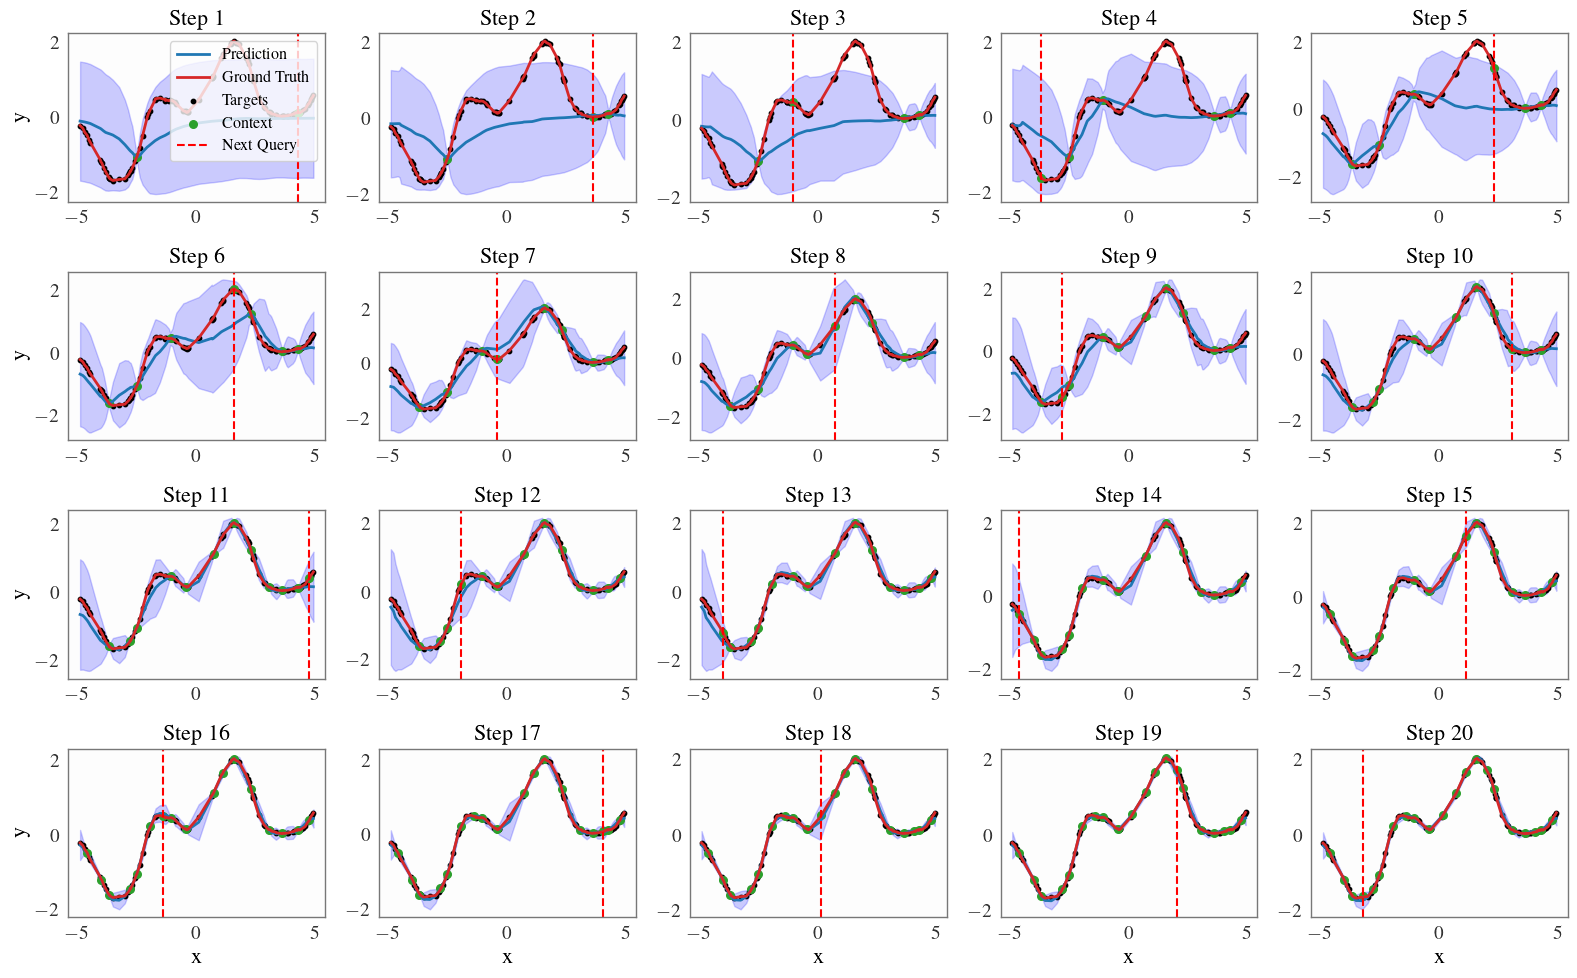

In [18]:
batch = copy.deepcopy(eval_set)
log_probs_ours, rmse_ours = calculate_targeted_log_prob(batch, cfg, model, experiment, 20, acquisition="aline", attend_to="data", visualize=True)

In [19]:
batch = copy.deepcopy(eval_set)
log_probs_us, rmse_us = calculate_targeted_log_prob(batch, cfg, model, experiment, T, acquisition="uncertainty_sampling", attend_to="data", visualize=False)

In [109]:
batch = copy.deepcopy(eval_set)
log_probs_gp_rs, rmse_gp_rs = active_learning_with_gp(batch, acquisition_function="random", n_iterations=T, visualize=False)

batch = copy.deepcopy(eval_set)
log_probs_gp_us, rmse_gp_us = active_learning_with_gp(batch, acquisition_function="uncertainty", n_iterations=T, visualize=False)

batch = copy.deepcopy(eval_set)
log_probs_gp_vr, rmse_gp_vr = active_learning_with_gp(batch, acquisition_function="variance_reduction", n_iterations=T, visualize=False)

batch = copy.deepcopy(eval_set)
log_probs_gp_epig, rmse_gp_epig = active_learning_with_gp(batch, acquisition_function="epig", n_iterations=T, visualize=False)

synthetic1d_gp_rmse = {"random": rmse_gp_rs, 
                       "uncertainty": rmse_gp_us, 
                       "variance_reduction": rmse_gp_vr, 
                       "epig": rmse_gp_epig,
                       "ace_us": rmse_us.detach().numpy(),
                       "aline": rmse_ours.detach().numpy()}

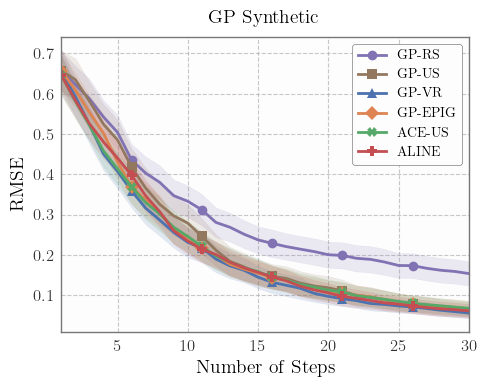

In [23]:
metrics_data = [
    synthetic1d_gp_rmse["random"],
    synthetic1d_gp_rmse["uncertainty"], 
    synthetic1d_gp_rmse["variance_reduction"], 
    synthetic1d_gp_rmse["epig"],
    synthetic1d_gp_rmse["ace_us"],
    synthetic1d_gp_rmse["aline"]
]

metric_names = ["GP-RS", "GP-US", "GP-VR", "GP-EPIG", "ACE-US", "ALINE"]

# Create the plot
fig, ax = plot_metrics_with_confidence(
    metrics_data,
    metric_names,
    x_range=(1, T),
    title="GP Synthetic"
)

# Show the plot
plt.show()

In [24]:
cfg, model = load_config_and_model(
    path="results/active_learning/aline_2d/",
    file_name="ckpt_al_2d.tar"
)

results/active_learning/aline_2d/.hydra/


In [25]:
batch_size = 100
T = 50

In [26]:
cfg.task.n_query_init = 500
experiment = hydra.utils.instantiate(cfg.task)

eval_set = experiment.sample_batch(batch_size)

In [27]:
batch = copy.deepcopy(eval_set)
log_probs_ours, rmse_ours = calculate_targeted_log_prob(batch, cfg, model, experiment, T, acquisition="aline", attend_to="data", visualize=False)

batch = copy.deepcopy(eval_set)
log_probs_us, rmse_us = calculate_targeted_log_prob(batch, cfg, model, experiment, T, acquisition="uncertainty_sampling", attend_to="data", visualize=False)

In [149]:
batch = copy.deepcopy(eval_set)
log_probs_gp_rs, rmse_gp_rs = active_learning_with_gp(batch, acquisition_function="random", n_iterations=T, visualize=False)

batch = copy.deepcopy(eval_set)
log_probs_gp_us, rmse_gp_us = active_learning_with_gp(batch, acquisition_function="uncertainty", n_iterations=T, visualize=False)

batch = copy.deepcopy(eval_set)
log_probs_gp_vr, rmse_gp_vr = active_learning_with_gp(batch, acquisition_function="variance_reduction", n_iterations=T, visualize=False)

batch = copy.deepcopy(eval_set)
log_probs_gp_epig, rmse_gp_epig = active_learning_with_gp(batch, acquisition_function="epig", n_iterations=T, visualize=False)

synthetic2d_gp_rmse = {"random": rmse_gp_rs, 
                       "uncertainty": rmse_gp_us, 
                       "variance_reduction": rmse_gp_vr, 
                       "epig": rmse_gp_epig,
                       "ace_us": rmse_us.detach().numpy(),
                       "aline": rmse_ours.detach().numpy()}

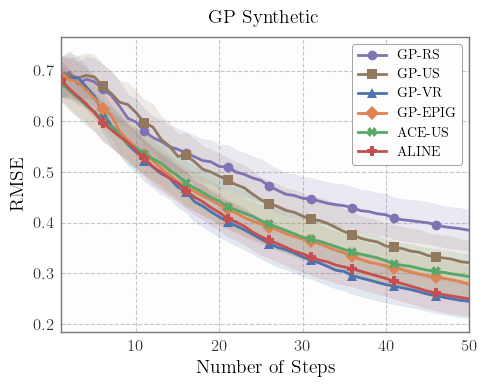

In [28]:
metrics_data = [
    synthetic2d_gp_rmse["random"],
    synthetic2d_gp_rmse["uncertainty"], 
    synthetic2d_gp_rmse["variance_reduction"], 
    synthetic2d_gp_rmse["epig"],
    synthetic2d_gp_rmse["ace_us"],
    synthetic2d_gp_rmse["aline"]
]

metric_names = ["GP-RS", "GP-US", "GP-VR", "GP-EPIG", "ACE-US", "ALINE"]

# Create the plot
fig, ax = plot_metrics_with_confidence(
    metrics_data,
    metric_names,
    x_range=(1, T),
    title="GP Synthetic"
)

# Show the plot
plt.show()

# Benchmark functions

In [29]:
cfg, model = load_config_and_model(
    path="results/active_learning/aline_1d/",
    file_name="ckpt_al_1d.tar"
)

results/active_learning/aline_1d/.hydra/


In [30]:
T = 30
benchmark = BenchmarkTask(dim_x = cfg.task.dim_x,  # dimension of input
                          dim_y = cfg.task.dim_y,  # dimension of output
                          n_context_init = 1,  # number of initial context points
                          n_query_init = 500,  # number of initial query points
                          n_target_data = cfg.task.n_target_data,  # number of target points
                          design_scale = 5,  # scale of the design space (-design_scale to design_scale)
                          noise_scale= 0.01)

In [32]:
gramacy1d = benchmark.sample_batch(100, 'gramacy1d', "mix")
batch = copy.deepcopy(gramacy1d)
log_probs_ours, rmse_ours = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="aline", attend_to="data", visualize=False)

batch = copy.deepcopy(gramacy1d)
log_probs_us, rmse_us = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="uncertainty_sampling", attend_to="data", visualize=False)

In [33]:
batch = copy.deepcopy(gramacy1d)
log_probs_gp_rs, rmse_gp_rs = active_learning_with_gp(batch, acquisition_function="random", n_iterations=T, visualize=False)

batch = copy.deepcopy(gramacy1d)
log_probs_gp_us, rmse_gp_us = active_learning_with_gp(batch, acquisition_function="uncertainty", n_iterations=T, visualize=False)

batch = copy.deepcopy(gramacy1d)
log_probs_gp_vr, rmse_gp_vr = active_learning_with_gp(batch, acquisition_function="variance_reduction", n_iterations=T, visualize=False)

batch = copy.deepcopy(gramacy1d)
log_probs_gp_epig, rmse_gp_epig = active_learning_with_gp(batch, acquisition_function="epig", n_iterations=T, visualize=False)

gramacy1d_gp_rmse = {"random": rmse_gp_rs, 
                       "uncertainty": rmse_gp_us, 
                       "variance_reduction": rmse_gp_vr, 
                       "epig": rmse_gp_epig,
                       "ace_us": rmse_us.detach().numpy(),
                       "aline": rmse_ours.detach().numpy()}

In [35]:
metrics_data = [
    gramacy1d_gp_rmse["random"],
    gramacy1d_gp_rmse["uncertainty"], 
    gramacy1d_gp_rmse["variance_reduction"], 
    gramacy1d_gp_rmse["epig"],
    gramacy1d_gp_rmse["ace_us"],
    gramacy1d_gp_rmse["aline"]
]

In [ ]:
higdon = benchmark.sample_batch(100, 'higdon', 'mix')
batch = copy.deepcopy(higdon)
log_probs_ours, rmse_ours = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="aline", attend_to="data", visualize=False)

batch = copy.deepcopy(higdon)
log_probs_us, rmse_us = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="uncertainty_sampling", attend_to="data", visualize=False)

In [157]:
batch = copy.deepcopy(higdon)
log_probs_gp_rs, rmse_gp_rs = active_learning_with_gp(batch, acquisition_function="random", n_iterations=T, visualize=False)

batch = copy.deepcopy(higdon)
log_probs_gp_us, rmse_gp_us = active_learning_with_gp(batch, acquisition_function="uncertainty", n_iterations=T, visualize=False)

batch = copy.deepcopy(higdon)
log_probs_gp_vr, rmse_gp_vr = active_learning_with_gp(batch, acquisition_function="variance_reduction", n_iterations=T, visualize=False)

batch = copy.deepcopy(higdon)
log_probs_gp_epig, rmse_gp_epig = active_learning_with_gp(batch, acquisition_function="epig", n_iterations=T, visualize=False)

higdon1d_gp_rmse = {"random": rmse_gp_rs, 
                       "uncertainty": rmse_gp_us, 
                       "variance_reduction": rmse_gp_vr, 
                       "epig": rmse_gp_epig,
                       "ace_us": rmse_us.detach().numpy(),
                       "aline": rmse_ours.detach().numpy()}

In [36]:
metrics_data = [
    higdon1d_gp_rmse["random"],
    higdon1d_gp_rmse["uncertainty"], 
    higdon1d_gp_rmse["variance_reduction"], 
    higdon1d_gp_rmse["epig"],
    higdon1d_gp_rmse["ace_us"],
    higdon1d_gp_rmse["aline"]
]

## 2D

In [37]:
cfg, model = load_config_and_model(
    path="results/active_learning/aline_2d/",
    file_name="ckpt_al_2d.tar"
)

results/active_learning/aline_2d/.hydra/


In [334]:
T = 50
benchmark = BenchmarkTask(dim_x = cfg.task.dim_x,  # dimension of input
                          dim_y = cfg.task.dim_y,  # dimension of output
                          n_context_init = 1,  # number of initial context points
                          n_query_init = 500,  # number of initial query points
                          n_target_data = cfg.task.n_target_data,  # number of target points
                          design_scale = 4,  # scale of the design space (-design_scale to design_scale)
                          noise_scale= 0.01)

In [59]:
branin = benchmark.sample_batch(100, 'branin', 'mix')
batch = copy.deepcopy(branin)
log_probs_ours, rmse_ours = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="aline", attend_to="data", visualize=False)

batch = copy.deepcopy(branin)
log_probs_us, rmse_us = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="uncertainty_sampling", attend_to="data", visualize=False)

In [162]:
batch = copy.deepcopy(branin)
log_probs_gp_rs, rmse_gp_rs = active_learning_with_gp(batch, acquisition_function="random", n_iterations=T, visualize=False)

batch = copy.deepcopy(branin)
log_probs_gp_us, rmse_gp_us = active_learning_with_gp(batch, acquisition_function="uncertainty", n_iterations=T, visualize=False)

batch = copy.deepcopy(branin)
log_probs_gp_vr, rmse_gp_vr = active_learning_with_gp(batch, acquisition_function="variance_reduction", n_iterations=T, visualize=False)

batch = copy.deepcopy(branin)
log_probs_gp_epig, rmse_gp_epig = active_learning_with_gp(batch, acquisition_function="epig", n_iterations=T, visualize=False)

branin2d_gp_rmse = {"random": rmse_gp_rs, 
                       "uncertainty": rmse_gp_us, 
                       "variance_reduction": rmse_gp_vr, 
                       "epig": rmse_gp_epig,
                       "ace_us": rmse_us.detach().numpy(),
                       "aline": rmse_ours.detach().numpy()}

In [38]:
metrics_data = [
    branin2d_gp_rmse["random"],
    branin2d_gp_rmse["uncertainty"], 
    branin2d_gp_rmse["variance_reduction"], 
    branin2d_gp_rmse["epig"],
    branin2d_gp_rmse["ace_us"],
    branin2d_gp_rmse["aline"]
]

In [ ]:
gramacy2d = benchmark.sample_batch(100, 'gramacy2d', 'mix')
batch = copy.deepcopy(gramacy2d)
log_probs_ours, rmse_ours = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="aline", attend_to="data", visualize=False)

batch = copy.deepcopy(gramacy2d)
log_probs_us, rmse_us = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="uncertainty_sampling", attend_to="data", visualize=False)

In [ ]:
batch = copy.deepcopy(gramacy2d)
log_probs_gp_rs, rmse_gp_rs = active_learning_with_gp(batch, acquisition_function="random", n_iterations=T, visualize=False)

batch = copy.deepcopy(gramacy2d)
log_probs_gp_us, rmse_gp_us = active_learning_with_gp(batch, acquisition_function="uncertainty", n_iterations=T, visualize=False)

batch = copy.deepcopy(gramacy2d)
log_probs_gp_vr, rmse_gp_vr = active_learning_with_gp(batch, acquisition_function="variance_reduction", n_iterations=T, visualize=False)

batch = copy.deepcopy(gramacy2d)
log_probs_gp_epig, rmse_gp_epig = active_learning_with_gp(batch, acquisition_function="epig", n_iterations=T, visualize=False)

gramacy2d_gp_rmse = {"random": rmse_gp_rs, 
                       "uncertainty": rmse_gp_us, 
                       "variance_reduction": rmse_gp_vr, 
                       "epig": rmse_gp_epig,
                       "ace_us": rmse_us.detach().numpy(),
                       "aline": rmse_ours.detach().numpy()}

In [ ]:
metrics_data = [
    gramacy2d_gp_rmse["random"],
    gramacy2d_gp_rmse["uncertainty"], 
    gramacy2d_gp_rmse["variance_reduction"], 
    gramacy2d_gp_rmse["epig"],
    gramacy2d_gp_rmse["ace_us"],
    gramacy2d_gp_rmse["aline"],
]

In [ ]:
goldstein_price = benchmark.sample_batch(100, 'goldstein_price', 'mix')
batch = copy.deepcopy(goldstein_price)
log_probs_ours, rmse_ours = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="aline", attend_to="data", visualize=False)

batch = copy.deepcopy(goldstein_price)
log_probs_us, rmse_us = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="uncertainty_sampling", attend_to="data", visualize=False)

In [ ]:
batch = copy.deepcopy(goldstein_price)
log_probs_gp_rs, rmse_gp_rs = active_learning_with_gp(batch, acquisition_function="random", n_iterations=T, visualize=False)

batch = copy.deepcopy(goldstein_price)
log_probs_gp_us, rmse_gp_us = active_learning_with_gp(batch, acquisition_function="uncertainty", n_iterations=T, visualize=False)

batch = copy.deepcopy(goldstein_price)
log_probs_gp_vr, rmse_gp_vr = active_learning_with_gp(batch, acquisition_function="variance_reduction", n_iterations=T, visualize=False)

batch = copy.deepcopy(goldstein_price)
log_probs_gp_epig, rmse_gp_epig = active_learning_with_gp(batch, acquisition_function="epig", n_iterations=T, visualize=False)

goldstein_price2d_gp_rmse = {"random": rmse_gp_rs, 
                       "uncertainty": rmse_gp_us, 
                       "variance_reduction": rmse_gp_vr, 
                       "epig": rmse_gp_epig,
                       "ace_us": rmse_us.detach().numpy(),
                       "aline": rmse_ours.detach().numpy()}

In [ ]:
metrics_data = [
    goldstein_price2d_gp_rmse["random"],
    goldstein_price2d_gp_rmse["uncertainty"], 
    goldstein_price2d_gp_rmse["variance_reduction"], 
    goldstein_price2d_gp_rmse["epig"],
    goldstein_price2d_gp_rmse["ace_us"],
    goldstein_price2d_gp_rmse["aline"]
]

In [ ]:
ood_benchmark = benchmark.sample_batch(100, 'three_hump_camel', 'mix')
batch = copy.deepcopy(ood_benchmark)
log_probs_ours, rmse_ours = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="aae", attend_to="data", visualize=False)

batch = copy.deepcopy(ood_benchmark)
log_probs_us, rmse_us = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="uncertainty_sampling", attend_to="data", visualize=False)

In [ ]:
batch = copy.deepcopy(ood_benchmark)
log_probs_gp_rs, rmse_gp_rs = active_learning_with_gp(batch, acquisition_function="random", n_iterations=T, visualize=False)

batch = copy.deepcopy(ood_benchmark)
log_probs_gp_us, rmse_gp_us = active_learning_with_gp(batch, acquisition_function="uncertainty", n_iterations=T, visualize=False)

batch = copy.deepcopy(ood_benchmark)
log_probs_gp_vr, rmse_gp_vr = active_learning_with_gp(batch, acquisition_function="variance_reduction", n_iterations=T, visualize=False)

batch = copy.deepcopy(ood_benchmark)
log_probs_gp_epig, rmse_gp_epig = active_learning_with_gp(batch, acquisition_function="epig", n_iterations=T, visualize=False)

three_hump_camel_benchmark_gp_rmse = {"random": rmse_gp_rs, 
                       "uncertainty": rmse_gp_us, 
                       "variance_reduction": rmse_gp_vr, 
                       "epig": rmse_gp_epig,
                       "ace_us": rmse_us.detach().numpy(),
                       "aline": rmse_ours.detach().numpy()}

In [ ]:
metrics_data = [
    three_hump_camel_benchmark_gp_rmse["random"],
    three_hump_camel_benchmark_gp_rmse["uncertainty"], 
    three_hump_camel_benchmark_gp_rmse["variance_reduction"], 
    three_hump_camel_benchmark_gp_rmse["epig"],
    three_hump_camel_benchmark_gp_rmse["ace_us"],
    three_hump_camel_benchmark_gp_rmse["aline"]
]


In [140]:
benchmark = BenchmarkTask(dim_x = cfg.task.dim_x,  # dimension of input
                          dim_y = cfg.task.dim_y,  # dimension of output
                          n_context_init = 1,  # number of initial context points
                          n_query_init = 500,  # number of initial query points
                          n_target_data = cfg.task.n_target_data,  # number of target points
                          design_scale = 2,  # scale of the design space (-design_scale to design_scale)
                          noise_scale= 0.01)

In [141]:
ackley2d = benchmark.sample_batch(100, 'ackley2d', 'mix')
batch = copy.deepcopy(ackley2d)
log_probs_ours, rmse_ours = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="aline", attend_to="data", visualize=False)

batch = copy.deepcopy(ackley2d)
log_probs_us, rmse_us = calculate_targeted_log_prob(batch, cfg, model, benchmark, T, acquisition="uncertainty_sampling", attend_to="data", visualize=False)

In [142]:
batch = copy.deepcopy(ackley2d)
log_probs_gp_rs, rmse_gp_rs = active_learning_with_gp(batch, acquisition_function="random", n_iterations=T, visualize=False)

batch = copy.deepcopy(ackley2d)
log_probs_gp_us, rmse_gp_us = active_learning_with_gp(batch, acquisition_function="uncertainty", n_iterations=T, visualize=False)

batch = copy.deepcopy(ackley2d)
log_probs_gp_vr, rmse_gp_vr = active_learning_with_gp(batch, acquisition_function="variance_reduction", n_iterations=T, visualize=False)

batch = copy.deepcopy(ackley2d)
log_probs_gp_epig, rmse_gp_epig = active_learning_with_gp(batch, acquisition_function="epig", n_iterations=T, visualize=False)

ackley2d_gp_rmse = {"random": rmse_gp_rs, 
                       "uncertainty": rmse_gp_us, 
                       "variance_reduction": rmse_gp_vr, 
                       "epig": rmse_gp_epig,
                       "ace_us": rmse_us.detach().numpy(),
                       "aline": rmse_ours.detach().numpy()}

In [39]:
metrics_data = [
    ackley2d_gp_rmse["random"],
    ackley2d_gp_rmse["uncertainty"], 
    ackley2d_gp_rmse["variance_reduction"], 
    ackley2d_gp_rmse["epig"],
    ackley2d_gp_rmse["ace_us"],
    ackley2d_gp_rmse["aline"],
]

In [344]:
all_results = {"synthetic1d": synthetic1d_gp_rmse,
               "synthetic2d": synthetic2d_gp_rmse,
               "gramacy1d": gramacy1d_gp_rmse,
               "gramacy2d": gramacy2d_gp_rmse,
               "golden_price2d": goldstein_price2d_gp_rmse,
               "ackley2d": ackley2d_gp_rmse,
               "branin2d": branin2d_gp_rmse,
               "higdon1d": higdon1d_gp_rmse,
               "three_hump_camel2d": three_hump_camel_benchmark_gp_rmse
               }

with open("results/active_learning/benchmark_results.pkl", 'wb') as f:
    pickle.dump(all_results, f)

In [20]:
with open("results/active_learning/benchmark_results.pkl", 'rb') as f:
    all_results = pickle.load(f)

In [41]:
synthetic1d_gp_rmse = all_results["synthetic1d"]
synthetic2d_gp_rmse = all_results["synthetic2d"]
gramacy1d_gp_rmse = all_results["gramacy1d"]
gramacy2d_gp_rmse = all_results["gramacy2d"]
goldstein_price2d_gp_rmse = all_results["golden_price2d"]
ackley2d_gp_rmse = all_results["ackley2d"]
branin2d_gp_rmse = all_results["branin2d"]
higdon1d_gp_rmse = all_results["higdon1d"]
three_hump_camel_benchmark_gp_rmse = all_results["three_hump_camel2d"]

In [42]:
def plot_multiple_metrics(
    all_data_dicts,
    benchmark_names,
    method_names,
    method_colors,  # Pre-defined colors for each method
    method_display_names=None,  # Optional display names for legend
    x_ranges=None,
    markers=None,
    title="",
    xlabel="Number of Steps $t$",
    ylabel="RMSE",
    figsize=None,
    marker_frequency=5,
    shared_ylim=False,
    dpi=120,
    grid_layout=(1, -1)
):
    """
    Plot metrics for multiple benchmarks with pre-defined colors for each method.
    
    Parameters:
    -----------
    all_data_dicts : list of dictionaries
        Each dictionary contains method names as keys and data arrays as values
    benchmark_names : list of str
        Names of benchmarks
    method_names : list of str
        Names of methods to plot in desired order
    method_colors : dict
        Dictionary mapping method names to colors
    method_display_names : dict, optional
        Dictionary mapping method names to display names for legend
    x_ranges : list of tuple, optional
        List of (min, max) for x-axis ranges for each benchmark
    markers : dict, optional
        Dictionary mapping method names to markers
    """
    n_benchmarks = len(all_data_dicts)

    nrows, ncols = grid_layout
    if ncols == -1:
        ncols = int(np.ceil(n_benchmarks / nrows))
    elif nrows == -1:
        nrows = int(np.ceil(n_benchmarks / ncols))
    
    # Set default display names if not provided
    if method_display_names is None:
        method_display_names = {name: name for name in method_names}
    
    # Set default x_ranges if not provided
    if x_ranges is None:
        x_ranges = [(1, 30)] * n_benchmarks
    
    # Set default markers if not provided
    if markers is None:
        default_markers = ['o', 's', '^', 'D', 'X', 'P']
        markers = {name: default_markers[i % len(default_markers)] 
                  for i, name in enumerate(method_names)}
    
    # Set default figsize if not provided
    if figsize is None:
        figsize = (3.5 * n_benchmarks, 4)
    
    # Set style
    # plt.style.use('seaborn-v0_8')
    plt.style.use('default')
    plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})
    
    # Create figure with subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi)
    if n_benchmarks == 1:
        axes = [axes]

    axes = np.array(axes).reshape(-1)
    
    # For storing global y limits if needed
    global_ymin, global_ymax = float('inf'), float('-inf')
    
    # For storing legend handles
    legend_handles = []
    
    # Plot each benchmark
    for i, (data_dict, benchmark_name, x_range) in enumerate(zip(all_data_dicts, benchmark_names, x_ranges)):
        ax = axes[i]
        x = np.arange(x_range[0], x_range[1] + 1)
        
        # Plot each method in the specified order
        local_ymin, local_ymax = float('inf'), float('-inf')
        
        for method in method_names:
            if method not in data_dict or data_dict[method] is None:
                continue
            
            data = data_dict[method]
            
            # Convert to numpy if it's a torch tensor
            if torch.is_tensor(data):
                data = data.detach().numpy()
            
            # Get color and marker for this method
            color = method_colors[method]
            marker = markers[method]
            
            # Calculate mean and confidence interval
            mean = data.mean(axis=1)
            std = data.std(axis=1)
            n_trials = data.shape[1]
            ci = 1.96 * std / np.sqrt(n_trials)  # 95% confidence interval
            
            # Ensure data length matches x-axis length
            if mean.shape[0] > len(x):
                mean = mean[:len(x)]
                ci = ci[:len(x)]
            
            # Plot the line with confidence band
            if method == "aline":
                line = ax.plot(x, mean, color=color, marker=marker, 
                          markevery=marker_frequency, markersize=10, 
                          linewidth=2.3)[0]
            else:
                line = ax.plot(x, mean, color=color, marker=marker, markevery=marker_frequency, markersize=5,linewidth=2)[0]
            
            ax.fill_between(x, mean - ci, mean + ci, color=color, alpha=0.15)
            
            # Store legend handle for the first subplot only
            if i == 0:
                legend_handles.append(line)
            
            # Update y limits
            valid_min = np.nanmin(mean - ci) if not np.isnan(mean - ci).all() else float('inf')
            valid_max = np.nanmax(mean + ci) if not np.isnan(mean + ci).all() else float('-inf')
            
            local_ymin = min(local_ymin, valid_min)
            local_ymax = max(local_ymax, valid_max)
        
        # Update global y limits
        global_ymin = min(global_ymin, local_ymin)
        global_ymax = max(global_ymax, local_ymax)
        
        # Customize plot appearance
        ax.set_xlabel(xlabel, fontsize=12)
        # ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

        for j in range(min(ncols, n_benchmarks)):
            row_idx = 0  # First row
            ax_idx = row_idx * ncols + j
            if ax_idx < len(axes):
                axes[ax_idx].set_xlabel('')
                # axes[ax_idx].tick_params(axis='x', labelbottom=False)

                
        # Replace the current y-label condition:
        if i % ncols == 0:
            ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
        
        # With this updated condition that adds labels to the first plot of each row:
        if i % ncols == 0:  # First column in any row
            ax.set_ylabel(ylabel, fontsize=14, fontweight='regular')
            
        ax.set_title(benchmark_name, fontsize=12, fontweight='bold', pad=10)
        # ax.text(0.1, 0.84, benchmark_name, transform=ax.transAxes, fontsize=14, fontweight='bold')
        
        ax.tick_params(axis='both', which='major', labelsize=10)
        # ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(x_range[0], x_range[1])
        
        # Add minor ticks
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Apply y-axis limits
    if shared_ylim:
        # Add a margin for aesthetics
        margin = 0.1 * (global_ymax - global_ymin)
        for ax in axes:
            # ax.set_ylim(bottom=max(0, global_ymin - margin), top=global_ymax + margin)
            ax.set_ylim(bottom=0, top=global_ymax + margin)
    else:
        # Adjust each plot individually
        for ax in axes:
            ylim = ax.get_ylim()
            margin = 0.1 * (ylim[1] - ylim[0])
            # ax.set_ylim(bottom=max(0, ylim[0] - margin), top=ylim[1] + margin)
            ax.set_ylim(bottom=0)
            
    
    # Create legend with display names
    legend_labels = [method_display_names[method] for method in method_names 
                    if method in data_dict and data_dict[method] is not None]
    
    # Add legend at the bottom
    fig.legend(legend_handles, legend_labels, loc='lower center', 
              bbox_to_anchor=(0.52, -0.05), ncol=min(6, len(legend_labels)), 
              frameon=True, framealpha=1, edgecolor='gray', fontsize=11)
    
    # Adjust layout
    plt.tight_layout()
    # plt.subplots_adjust(bottom=0.2)
    plt.subplots_adjust(bottom=0.15, hspace=0.45)
    
    # Add overall title if provided
    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold', y=1.05)
        plt.subplots_adjust(top=0.85)
    
    return fig, axes

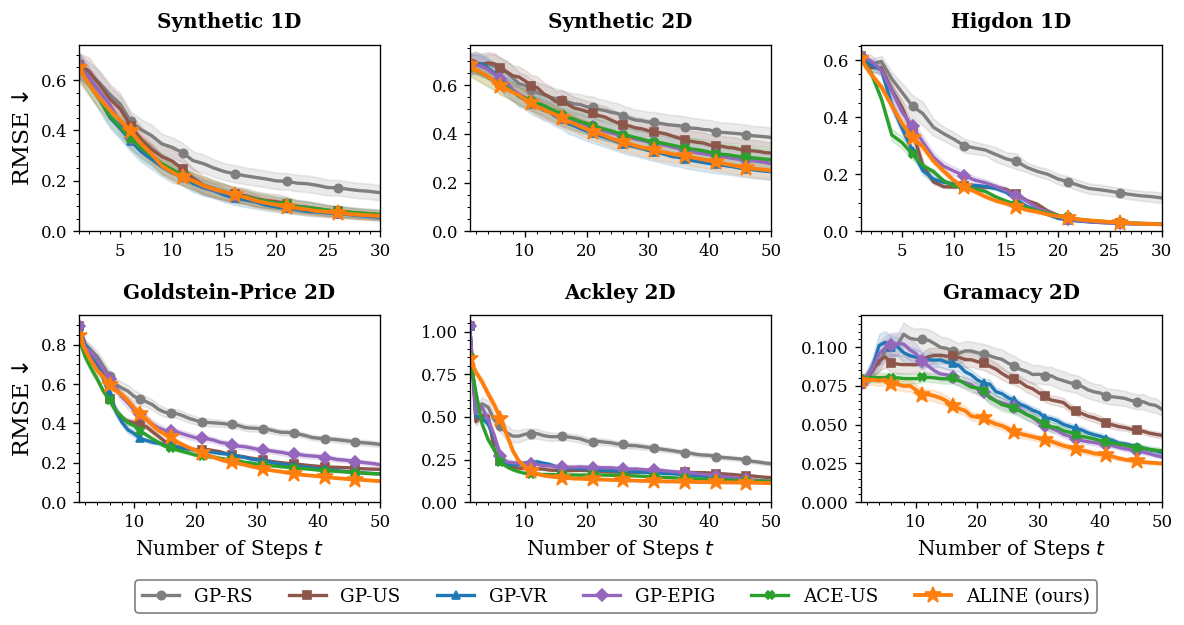

In [43]:
# Define method names, colors, and display names
method_names = ["random", "uncertainty", "variance_reduction", "epig", "ace_us", "aline"]

# Pre-define colors - using Seaborn color palette with ALINE as orange (C1)
palette = sns.color_palette()
method_colors = {
    "random": "tab:grey",        
    "uncertainty": "C5",   
    "variance_reduction": "C0",
    "epig": "C4",         
    "ace_us": "tab:green", 
    "aline": "tab:orange"
}

# Define display names
method_display_names = {
    "random": "GP-RS",
    "uncertainty": "GP-US", 
    "variance_reduction": "GP-VR", 
    "epig": "GP-EPIG", 
    "ace_us": "ACE-US", 
    "aline": "ALINE (ours)"
}

# Define markers (optional)
method_markers = {
    "random": "o",
    "uncertainty": "s", 
    "variance_reduction": "^", 
    "epig": "D", 
    "ace_us": "X", 
    "aline": "*"
}

# Define benchmark names and x-ranges
benchmark_names = ["Synthetic 1D", "Synthetic 2D", "Higdon 1D", "Goldstein-Price 2D", "Ackley 2D", "Gramacy 2D"]
x_ranges = [(1, 30), (1, 50), (1, 30), (1, 50), (1, 50), (1, 50)]

# Create the plot
fig, axes = plot_multiple_metrics(
    all_data_dicts=[synthetic1d_gp_rmse, synthetic2d_gp_rmse, 
              higdon1d_gp_rmse, goldstein_price2d_gp_rmse, ackley2d_gp_rmse, gramacy2d_gp_rmse, ],
    benchmark_names=benchmark_names,
    method_names=method_names,
    method_colors=method_colors,
    method_display_names=method_display_names,
    markers=method_markers,
    x_ranges=x_ranges,
    title=None,
    ylabel="RMSE$\\downarrow$",
    figsize=(10, 5),
    shared_ylim=False,
    grid_layout=(2, 3)
)
plt.savefig('figures/al_main.pdf', bbox_inches='tight', dpi=300)
plt.show()

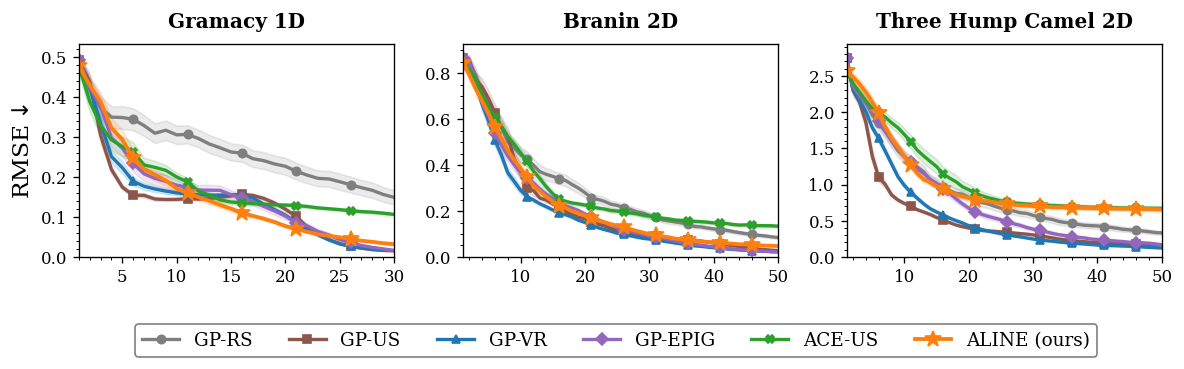

In [91]:
# Define method names, colors, and display names
method_names = ["random", "uncertainty", "variance_reduction", "epig", "ace_us", "aline"]

# Pre-define colors - using Seaborn color palette with ALINE as orange (C1)
palette = sns.color_palette()
method_colors = {
    "random": "tab:grey",        
    "uncertainty": "C5",   
    "variance_reduction": "C0",
    "epig": "C4",         
    "ace_us": "tab:green", 
    "aline": "tab:orange"
}

# Define display names
method_display_names = {
    "random": "GP-RS",
    "uncertainty": "GP-US", 
    "variance_reduction": "GP-VR", 
    "epig": "GP-EPIG", 
    "ace_us": "ACE-US", 
    "aline": "ALINE (ours)"
}

# Define markers (optional)
method_markers = {
    "random": "o",
    "uncertainty": "s", 
    "variance_reduction": "^", 
    "epig": "D", 
    "ace_us": "X", 
    "aline": "*"
}

# Define benchmark names and x-ranges
benchmark_names = ["Gramacy 1D", "Branin 2D", "Three Hump Camel 2D"]
x_ranges = [(1, 30), (1, 50), (1, 50)]

# Create the plot
fig, axes = plot_multiple_metrics(
    all_data_dicts=[gramacy1d_gp_rmse, branin2d_gp_rmse, three_hump_camel_benchmark_gp_rmse],
    benchmark_names=benchmark_names,
    method_names=method_names,
    method_colors=method_colors,
    method_display_names=method_display_names,
    markers=method_markers,
    x_ranges=x_ranges,
    title=None,
    ylabel="RMSE$\\downarrow$",
    figsize=(10, 2.6),
    shared_ylim=False,
    grid_layout=(1, 3)
)
plt.savefig('figures/al_addition.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Posterior

In [46]:
cfg, model = load_config_and_model(
    path="results/active_learning/aline_2d/",
    file_name="ckpt_al_2d.tar"
)
cfg.task.n_query_init = 200

results/gaussian_process/mix_mode/2d_gamma1/.hydra/


In [62]:
batch_size = 200
T = 30
experiment = hydra.utils.instantiate(cfg.task)
eval_set = experiment.sample_batch(batch_size)

In [72]:
# torch.save(eval_set, "data/al_posterior_eval_set.pt")
eval_set = torch.load("data/al_posterior_eval_set.pt", weights_only=False)

In [73]:
batch = copy.deepcopy(eval_set)
log_probs_ours, rmse_ours = calculate_targeted_log_prob(batch, cfg, model, experiment, T, acquisition="aline", attend_to="theta", visualize=False)

batch = copy.deepcopy(eval_set)
log_probs_us, rmse_us = calculate_targeted_log_prob(batch, cfg, model, experiment, T, acquisition="uncertainty_sampling", attend_to="theta", visualize=False)

batch = copy.deepcopy(eval_set)
log_probs_rs, rmse_rs = calculate_targeted_log_prob(batch, cfg, model, experiment, T, acquisition="random", attend_to="theta", visualize=False)

In [74]:
posterior_rmse = {"random": rmse_rs.detach().numpy(), 
                  "ace_us": rmse_us.detach().numpy(),
                  "aline": rmse_ours.detach().numpy()}

posterior_log_probs = {"random": log_probs_rs.detach().numpy(), 
                  "ace_us": log_probs_us.detach().numpy(),
                  "aline": log_probs_ours.detach().numpy()}

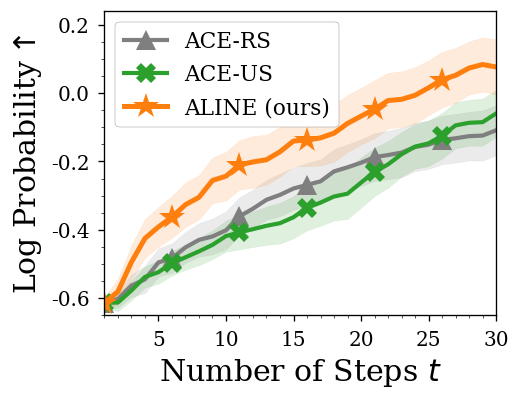

In [81]:
# Define method names, colors, and display names
method_names = ["random", "ace_us", "aline"]

# Pre-define colors - using Seaborn color palette with ALINE as orange (C1)
palette = sns.color_palette()
method_colors = {
    "random": "tab:grey",         
    "ace_us": "tab:green", 
    "aline": "tab:orange"
}

# Define display names
method_display_names = {
    "random": "ACE-RS", 
    "ace_us": "ACE-US", 
    "aline": "ALINE (ours)"
}

# Define markers (optional)
method_markers = {
    "random": "^", 
    "ace_us": "X", 
    "aline": "*"
}

# Set style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

# Create figure
fig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=120)

# Determine x-axis range
max_length = max(data.shape[0] for method, data in posterior_log_probs.items() 
                 if method in method_names and data is not None)
x_range = (1, max_length)
x = np.arange(x_range[0], x_range[1] + 1)

# Plot each method
legend_handles = []
marker_frequency = 5
line_width = 2.5
marker_size = 9

for method in method_names:
    if method not in posterior_log_probs or posterior_log_probs[method] is None:
        continue
    
    data = posterior_log_probs[method]
    
    # Convert to numpy if it's a torch tensor
    if torch.is_tensor(data):
        data = data.detach().numpy()
    
    color = method_colors[method]
    marker = method_markers[method]
    
    # Calculate mean and confidence interval
    mean = data.mean(axis=1)
    std = data.std(axis=1)
    n_trials = data.shape[1]
    ci = 1.96 * std / np.sqrt(n_trials)  # 95% confidence interval
    
    # Ensure data length matches x-axis
    mean = mean[:len(x)]
    ci = ci[:len(x)]
    
    # Plot line with confidence band
    if method == "aline":
        line = ax.plot(x, mean, color=color, marker=marker, 
                          markevery=marker_frequency, markersize=16, 
                          linewidth=3, label=method_display_names[method])[0]
    else:
        line = ax.plot(x, mean, color=color, marker=marker, 
                       markevery=marker_frequency, markersize=12,linewidth=2.5,
                      label=method_display_names[method])[0]
            
    
    ax.fill_between(x, mean - ci, mean + ci, color=color, alpha=0.15)

# Format y-axis ticks to display only one decimal place
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# Customize plot appearance
ax.set_xlabel("Number of Steps $t$", fontsize=18)
ax.set_ylabel("Log Probability$\\uparrow$", fontsize=18, fontweight='regular')
ax.set_title("", fontsize=16, fontweight='bold', pad=10)

ax.tick_params(axis='both', which='major', labelsize=12)
# ax.grid(True, linestyle='--', alpha=0.3)
ax.set_xlim(x_range[0], x_range[1])
ax.set_ylim(-0.65, 0.24)

# Add minor ticks
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

# Add legend inside the plot
ax.legend(loc='upper left', frameon=True, framealpha=1, 
         edgecolor='gray', fontsize=13)

plt.tight_layout()
plt.savefig('figures/al_posterior.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [275]:
def visualize_theta_posteriors(
    mixture_means,
    mixture_stds,
    mixture_weights,
    true_theta=None,
    param_names=None,
    n_samples_kde=100  # Number of samples for KDE
):
    batch_idx = 0

    # Get dimensions
    n_params = mixture_means.shape[1]
    n_components = mixture_means.shape[2]

    # Default parameter names
    if param_names is None:
        if n_params == 2:
            param_names = ["Lengthscale", "Variance"]
        elif n_params == 3:
            param_names = ["Lengthscale 1", "Lengthscale 2", "Scale"] # from original example
        else:
            param_names = [f"Parameter {k+1}" for k in range(n_params)]

    # Adjust weights if they don't have the parameter dimension
    if len(mixture_weights.shape) == 2:  # [batch_size, n_components]
        # Assume weights are shared across parameters if not specified per parameter
        weights_np = mixture_weights[batch_idx].detach().cpu().numpy()
        weights_np = np.expand_dims(weights_np, 0).repeat(n_params, axis=0)
    else:  # [batch_size, n_params, n_components]
        weights_np = mixture_weights[batch_idx].detach().cpu().numpy()

    # Convert to numpy
    means_np = mixture_means[batch_idx].detach().cpu().numpy()
    stds_np = mixture_stds[batch_idx].detach().cpu().numpy()

    # Create figure
    fig, axes = plt.subplots(n_params, 1, figsize=(3 , 2.8* n_params), squeeze=False)
    axes = axes.flatten() # Ensure axes is always a 1D array

    calculated_log_probs = []

    for i in range(n_params):
        ax = axes[i]
        param_means_i = means_np[i]  # Means for current parameter i's components
        param_stds_i = stds_np[i]    # Stds for current parameter i's components
        param_weights_i = weights_np[i]  # Weights for current parameter i's components

        # Ensure weights for current parameter sum to 1 for sampling and log-prob
        sum_weights = np.sum(param_weights_i)
        if sum_weights > 0 and not np.isclose(sum_weights, 1.0):
            param_weights_i = param_weights_i / sum_weights

        # --- Sample from GMM for parameter i ---
        # Ensure stds are positive for sampling
        param_stds_i_safe = np.maximum(param_stds_i, 1e-9) # Prevent zero or negative stds

        if n_components == 0:
            samples_i = np.array([])
        elif n_samples_kde == 0:
            samples_i = np.array([])
        else:
            # Choose components based on weights
            component_indices = np.random.choice(
                n_components,
                size=n_samples_kde,
                p=param_weights_i
            )
            # Sample from the chosen Gaussian components
            samples_i = norm.rvs(
                loc=param_means_i[component_indices],
                scale=param_stds_i_safe[component_indices]
            )

        # Filter out NaNs or Infs from samples if any, as KDE can't handle them
        samples_i_finite = samples_i[np.isfinite(samples_i)]
        if samples_i_finite.size > 1:
            kde = gaussian_kde(samples_i_finite)
            
            # Create a range of x values for plotting KDE based on sample range
            s_min, s_max = np.min(samples_i_finite), np.max(samples_i_finite)
            plot_margin = (s_max - s_min) * 0.15
            if np.isclose(s_min, s_max): # All samples are (nearly) the same
                plot_margin = max(1.0, 0.1 * abs(s_min)) if s_min != 0 else 1.0

            x_range_kde = np.linspace(s_min - plot_margin, s_max + plot_margin, 300)

            # Ensure positive plot range for certain parameters (optional, based on domain knowledge)
            if param_names[i] in ["Lengthscale", "Variance", "Scale"] or "Lengthscale" in param_names[i] or "Variance" in param_names[i]:
                 current_min_x = max(x_range_kde[0], 0.0001) # Avoid exactly zero for log-scale if needed later
                 if current_min_x < x_range_kde[-1]:
                     x_range_kde = np.linspace(current_min_x, x_range_kde[-1], 300)


            kde_pdf = kde(x_range_kde)
            ax.plot(x_range_kde, kde_pdf, 'b-', linewidth=2, label="ALINE Posterior" if i == 0 else None)
            ax.fill_between(x_range_kde, kde_pdf, color='b', alpha=0.2)


        if true_theta is not None:
            true_val = true_theta[batch_idx, i].item()
            ax.axvline(x=true_val, color='r', linestyle='--', linewidth=2,
                        label="True Value" if i == 0 else None)
            

        ax.set_title(f"{param_names[i]} Posterior", fontsize=13)
        ax.set_xlabel(f"{param_names[i]} Value", fontsize=12)
        ax.set_ylabel("Density", fontsize=12)
        # if i == 0:
        #     ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust layout to make space for fig legend
    # plt.suptitle("Marginal Posteriors from GMM (via KDE)", fontsize=16) # Optional overall title
    plt.savefig("al_posterior_visualization_15.png", dpi=300, transparent=True)

In [261]:
# torch.save(eval_set, "data/al_posterior_visualization_eval_set.pt")
eval_set = torch.load("data/al_posterior_visualization_eval_set.pt", weights_only=False)

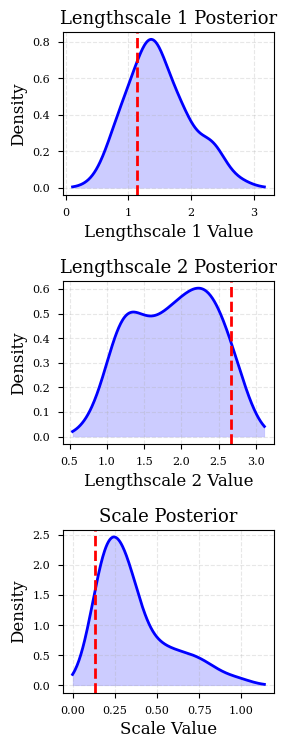

In [287]:
# eval_set = experiment.sample_batch(batch_size)
batch = copy.deepcopy(eval_set)
batch_size = batch.context_x.shape[0]
mask_type = cfg.task.mask_type[0]

batch.target_mask = create_target_mask(
    mask_type,
    cfg.task.embedding_type,
    cfg.task.n_target_data,
    cfg.task.n_target_theta,
    cfg.task.n_selected_targets,
    cfg.task.predefined_masks,
    None,
    cfg.task.mask_index,
    "theta",
)

# Initialize tensors to store results
log_probs = torch.zeros((T, batch_size), device=batch.context_x.device)
rmse_values = torch.zeros((T, batch_size), device=batch.context_x.device)

for t in range(T):
    if cfg.time_token:
        batch.t = torch.tensor([t/T])
        
    # Forward pass
    outs = model.forward(batch, predict=True)
    design_out = outs.design_out
    posterior_out = outs.posterior_out
    
    # Calculate log probability
    target_ll = compute_ll(
        batch.target_all,
        posterior_out.mixture_means,
        posterior_out.mixture_stds,
        posterior_out.mixture_weights
    )  # [batch_size, n_targets]

    # Calculate squared errors
    weighted_means = torch.sum(posterior_out.mixture_means * posterior_out.mixture_weights, dim=-1)  # [batch_size, n_targets]
    squared_errors = (batch.target_all.squeeze(-1) - weighted_means) ** 2  # [batch_size, n_targets]
    
    if mask_type == "none":
        masked_target_ll = target_ll
        # For RMSE, compute per-batch element (mean across targets, then sqrt)
        masked_target_rmse = torch.sqrt(torch.mean(squared_errors, dim=-1))  # [batch_size]
    else:
        masked_target_ll = select_targets_by_mask(target_ll, batch.target_mask)  # [batch_size, selected_targets]
        masked_squared_errors = select_targets_by_mask(squared_errors, batch.target_mask)  # [batch_size, selected_targets]
        masked_target_rmse = torch.sqrt(torch.mean(masked_squared_errors, dim=-1))  # [batch_size]
        
    # Store per-batch log probs (mean across selected targets)
    log_probs[t] = masked_target_ll.mean(dim=-1)  # [batch_size]
    rmse_values[t] = masked_target_rmse  # [batch_size]


    index = design_out.idx

        
    # Get the next design point
    next_design_x = torch.gather(
        batch.query_x, 1, 
        index.unsqueeze(2).expand(batch_size, 1, cfg.task.dim_x)
    )
    
    batch = experiment.update_batch(batch, index)
    if t==14:
        visualize_theta_posteriors(
            outs.posterior_out.mixture_means[:, batch.target_mask],
            outs.posterior_out.mixture_stds[:, batch.target_mask],
            outs.posterior_out.mixture_weights[:, batch.target_mask],
            true_theta=batch.target_theta)